# Libraries and s3 connexion

In [ ]:
!pip install -r requirements.txt

In [2]:
import numpy as np
import h5py
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os

In [3]:
fs = s3fs.S3FileSystem(
    client_kwargs={"endpoint_url": f'https://{os.environ["AWS_S3_ENDPOINT"]}'},
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"],
    token=os.environ["AWS_SESSION_TOKEN"],
)

# Load data

In [5]:
def download_s3_folder(fs, bucket_name, s3_folder, local_dir):
    """
    Télécharge tous les fichiers d'un dossier S3 dans un répertoire local.
    
    :param bucket_name: Nom du bucket S3.
    :param s3_folder: Chemin du dossier sur S3 à télécharger.
    :param local_dir: Chemin local où télécharger les fichiers.
    """
    files = fs.ls(f"{bucket_name}/{s3_folder}")

    for file in files:
        file_path = file.replace(bucket_name+s3_folder, "")
        local_file_path = os.path.join(local_dir, file_path)

        local_file_dir = os.path.dirname(local_file_path)
        if not os.path.exists(local_file_dir):
            os.makedirs(local_file_dir)

        print(f"Téléchargement de {file} vers {local_file_path}")
        fs.get(file, local_file_path)

# Téléchargement des données
bucket_name = 'projet-slums-detection/'
s3_folder = 'challenge_mexique/'
local_dir = 'data/'

download_s3_folder(fs, bucket_name, s3_folder, local_dir)


Téléchargement de projet-slums-detection/challenge_mexique/.keep vers data/.keep
Téléchargement de projet-slums-detection/challenge_mexique/SampleSubmission.csv vers data/SampleSubmission.csv
Téléchargement de projet-slums-detection/challenge_mexique/id_map.csv vers data/id_map.csv
Téléchargement de projet-slums-detection/challenge_mexique/test_data.h5 vers data/test_data.h5
Téléchargement de projet-slums-detection/challenge_mexique/train_data.h5 vers data/train_data.h5


## Train data

In [4]:
# Path to your HDF5 file
hdf5_file = "../data/train_data.h5"

# Open the HDF5 file
with h5py.File(hdf5_file, 'r') as hdf:
    # Extract the images (X)
    X = np.array(hdf['images'])
    
    # Extract the labels (y)
    y = np.array(hdf['labels'])

# Check the shapes to ensure they are correct
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)


/tmp/ipykernel_794805/4146447924.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X = np.array(hdf['images'])


Shape of X (images): (1100000, 16, 16, 6)
Shape of y (labels): (1100000,)


/tmp/ipykernel_794805/4146447924.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y = np.array(hdf['labels'])


### Visualize first image (uint16)

In [5]:
len(X)

1100000

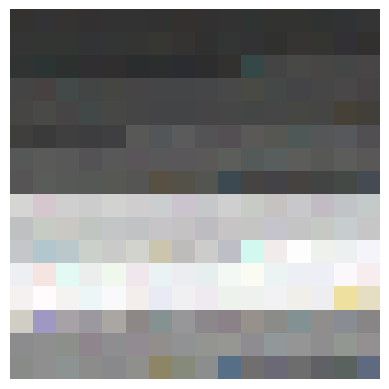

In [25]:
# plot l'image 50
image_array = X[300000]

rgb_image = np.stack([image_array[:, :, 3], image_array[:, :, 4], image_array[:, :, 5]], axis=-1)

# Normalize the image for display (optional if values exceed standard 8-bit range)
rgb_image_normalized = rgb_image / np.max(rgb_image)

# Plot the RGB image
plt.imshow(rgb_image_normalized)
plt.axis('off')
plt.show()

## Test data

In [ ]:
hdf5_file_test = "data/test_data.h5"
# Open the HDF5 file
with h5py.File(hdf5_file_test, 'r') as hdf:
    # Extract the images (X)
    X_test = np.array(hdf['images'])

# Check the shapes to ensure they are correct
print("Shape of X_test (images):", X_test.shape)

### Create y_test

In [ ]:
mapping = pd.read_csv("data/id_map.csv")

In [ ]:
sample = pd.read_csv("data/SampleSubmission.csv")

In [ ]:
y_test = pd.merge(sample, mapping, on="id")
y_test = y_test.sort_values(by="ID", ascending=True)
y_test = y_test.reset_index(drop=True)
y_test = np.array(y_test['class'])

### Balance data

In [ ]:
def balance_data(X, y, prop_of_zeros=0.5):
    # Step 1: Count the number of 1's in y
    num_ones = np.sum(y == 1)
    
    # Step 2: Get indices of 0's and 1's in y
    ones_indices = np.where(y == 1)[0]
    zeros_indices = np.where(y == 0)[0]
    
    # Step 3: Randomly sample the same number of 0's as there are 1's
    balanced_zero_indices = np.random.choice(zeros_indices, int(int(num_ones)*prop_of_zeros/(1-prop_of_zeros)), replace=False)
    
    # Step 4: Combine indices of 0's and 1's
    balanced_indices = np.concatenate([ones_indices, balanced_zero_indices])
    
    # Step 5: Create balanced X and y
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    # Display the number of 0's and 1's in the balanced y
    print(f"Number of 1's in balanced y: {np.sum(y_balanced == 1)}")
    print(f"Number of 0's in balanced y: {np.sum(y_balanced == 0)}")

    # Shuffle both X_balanced and y_balanced together
    X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=1)

    return X_balanced, y_balanced

In [73]:
X_balanced, y_balanced = balance_data(X, y)

Number of 1's in balanced y: 100000
Number of 0's in balanced y: 100000


### Split data

In [75]:
from sklearn.model_selection import train_test_split
import numpy as np

# Supposons que vous ayez X (features) et y (labels)
# X : np.array de vos matrices d'entrée (par exemple, shape (n_samples, 16, 16, 6))
# y : np.array de vos labels (0 ou 1), shape (n_samples,)

def split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2):
    # Vérifier que les tailles des splits sont cohérentes
    assert train_size + val_size + test_size == 1, "Les tailles des splits doivent être égales à 1"
    
    # Séparer les données par classe
    X_class0 = X[y == 0]
    X_class1 = X[y == 1]
    
    y_class0 = y[y == 0]
    y_class1 = y[y == 1]
    
    # Diviser chaque classe en train, validation, test
    # Classe 0
    X_train_0, X_temp_0, y_train_0, y_temp_0 = train_test_split(X_class0, y_class0, train_size=train_size, stratify=y_class0)
    X_val_0, X_test_0, y_val_0, y_test_0 = train_test_split(X_temp_0, y_temp_0, test_size=test_size/(test_size + val_size), stratify=y_temp_0)
    
    # Classe 1
    X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(X_class1, y_class1, train_size=train_size, stratify=y_class1)
    X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp_1, y_temp_1, test_size=test_size/(test_size + val_size), stratify=y_temp_1)
    
    # Combiner les données de classe 0 et classe 1
    X_train = np.concatenate([X_train_0, X_train_1], axis=0)
    y_train = np.concatenate([y_train_0, y_train_1], axis=0)
    
    X_val = np.concatenate([X_val_0, X_val_1], axis=0)
    y_val = np.concatenate([y_val_0, y_val_1], axis=0)
    
    X_test = np.concatenate([X_test_0, X_test_1], axis=0)
    y_test = np.concatenate([y_test_0, y_test_1], axis=0)
    
    # Shuffle les ensembles pour mélanger les classes
    train_indices = np.random.permutation(X_train.shape[0])
    val_indices = np.random.permutation(X_val.shape[0])
    test_indices = np.random.permutation(X_test.shape[0])
    
    X_train, y_train = X_train[train_indices], y_train[train_indices]
    X_val, y_val = X_val[val_indices], y_val[val_indices]
    X_test, y_test = X_test[test_indices], y_test[test_indices]
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [76]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X_balanced, y_balanced)

# Vérification de la taille des jeux de données
print("Taille des données d'entraînement :", X_train.shape, y_train.shape)
print("Taille des données de validation :", X_val.shape, y_val.shape)
print("Taille des données de test :", X_test.shape, y_test.shape)

Taille des données d'entraînement : (120000, 16, 16, 6) (120000,)
Taille des données de validation : (40000, 16, 16, 6) (40000,)
Taille des données de test : (40000, 16, 16, 6) (40000,)


## Entrainements

In [ ]:
# Tester la nouvelle architecture avec une entrée 16x16x6
x = torch.randn(1, 6, 16, 16)  # Batch de 1, 6 canaux, 16x16
output = model(x)

print(output.shape)  # Sortie du réseau